In [115]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split

from keras.layers import Embedding, LSTM, Dense, Flatten, Input, SimpleRNN, TextVectorization
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

## Загрузка и подготовка данных

In [242]:
data = pd.read_csv('WELFake_Dataset.csv')
data = data.dropna()
data.drop(columns=['Unnamed: 0'],inplace=True)

In [243]:
X = data.drop(columns=['label'])
y = data['label']

In [244]:
vocab_size = 40000

In [245]:
messages = X.copy()
messages.reset_index(inplace=True)

In [246]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

lm = WordNetLemmatizer()

stopwords = stopwords.words('english')
corpus = []
for i in range(len(messages)):
    review = re.sub('^a-zA-Z0-9',' ',messages['title'][i])
    review = re.sub(r'[^\w\s]', '', review)
    review = review.lower()
    review = review.split()
    review =[lm.lemmatize(x) for x in review if x not in stopwords]
    review = " ".join(review)
    corpus.append(review)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tainazitina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tainazitina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [247]:
max_length = max(len(sentence.split()) for sentence in corpus)
print("Maximum sentence length:", max_length)

Maximum sentence length: 46


In [248]:
max_words = 40000

tokenizer = TextVectorization(max_tokens=max_words)
tokenizer.adapt(corpus)
sequences = tokenizer(corpus)

vocabulary = tokenizer.get_vocabulary()

In [249]:
sentence_length = max_length+1
embedded_docs = pad_sequences(sequences,padding='post',maxlen=sentence_length)

In [250]:
X_final = np.array(embedded_docs)
y_final = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

In [251]:
def show_graph(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Accuracu')
  plt.legend()
  
  plt.figure()
  
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Loss')
  plt.legend()
  
  plt.show()

## Модель MLP с обучаемым слоем Embedding

In [252]:
embedding_dim = 300
model1 = Sequential()
model1.add(Input(shape=(sentence_length, )))
model1.add(Embedding(max_words, embedding_dim))
model1.add(Flatten())
model1.add(Dense(32, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [253]:
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1789/1789 [==============================] - 25s 14ms/step - loss: 0.2760 - acc: 0.8805 - val_loss: 0.2425 - val_acc: 0.9075
Epoch 2/10
1789/1789 [==============================] - 27s 15ms/step - loss: 0.1796 - acc: 0.9290 - val_loss: 0.2416 - val_acc: 0.9061
Epoch 3/10
1789/1789 [==============================] - 28s 15ms/step - loss: 0.1355 - acc: 0.9490 - val_loss: 0.2662 - val_acc: 0.8954
Epoch 4/10
1789/1789 [==============================] - 29s 16ms/step - loss: 0.1082 - acc: 0.9609 - val_loss: 0.2962 - val_acc: 0.8880
Epoch 5/10
1789/1789 [==============================] - 29s 16ms/step - loss: 0.0883 - acc: 0.9677 - val_loss: 0.3182 - val_acc: 0.8826
Epoch 6/10
1789/1789 [==============================] - 28s 16ms/step - loss: 0.0757 - acc: 0.9734 - val_loss: 0.3636 - val_acc: 0.8788
Epoch 7/10
1789/1789 [==============================] - 28s 16ms/step - loss: 0.0655 - acc: 0.9773 - val_loss: 0.4447 - val_acc: 0.8660
Epoch 8/10
1789/1789 [==========================

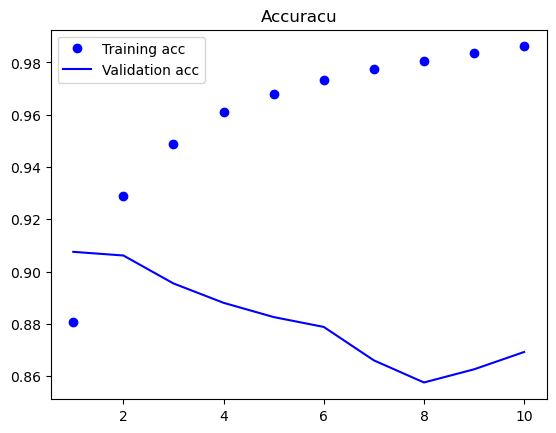

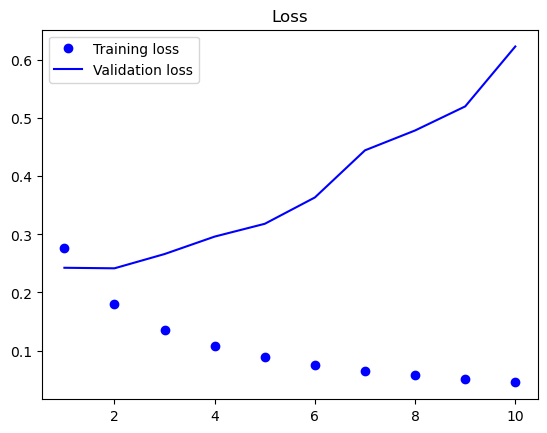

In [254]:
show_graph(history1)

## Модель MLP с предобученным слоем Embedding

In [255]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [256]:
hits = 0
misses = 0

embedding_matrix = np.zeros((max_words, embedding_dim))
i = 0
for word in vocabulary:
  i += 1
  if i < max_words:
    try: 
      embedding_vector = word_vectors[word]
      embedding_matrix[i] = embedding_vector
      hits += 1
    except:
      misses += 1

print("Convert %d words (%d mistakes)" % (hits, misses))

Convert 20861 words (12890 mistakes)


In [257]:
model2 = Sequential()
model2.add(Input(shape=(sentence_length, )))
model2.add(Embedding(max_words, embedding_dim))
model2.add(Flatten())
model2.add(Dense(32, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.layers[0].set_weights([embedding_matrix])
model2.layers[0].trainable = False

model2.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [258]:
history2 = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1789/1789 [==============================] - 6s 3ms/step - loss: 0.4213 - acc: 0.7954 - val_loss: 0.3883 - val_acc: 0.8130
Epoch 2/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.3428 - acc: 0.8427 - val_loss: 0.3738 - val_acc: 0.8263
Epoch 3/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.2794 - acc: 0.8785 - val_loss: 0.3771 - val_acc: 0.8341
Epoch 4/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.2136 - acc: 0.9154 - val_loss: 0.3921 - val_acc: 0.8403
Epoch 5/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1528 - acc: 0.9431 - val_loss: 0.4462 - val_acc: 0.8442
Epoch 6/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.1049 - acc: 0.9642 - val_loss: 0.4937 - val_acc: 0.8460
Epoch 7/10
1789/1789 [==============================] - 5s 3ms/step - loss: 0.0676 - acc: 0.9794 - val_loss: 0.5582 - val_acc: 0.8451
Epoch 8/10
1789/1789 [==============================] - 4s 3ms

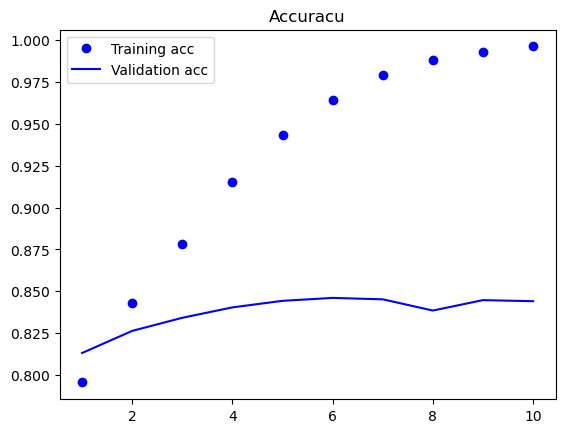

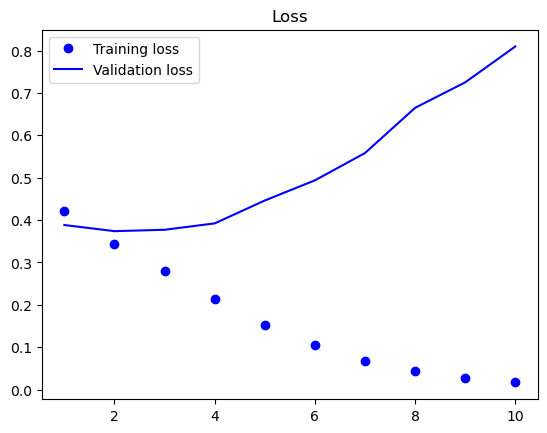

In [259]:
show_graph(history2)

## Рекуррентная модель со слоем SimpleRnn

In [260]:
model3 = Sequential()
model3.add(Input(shape=(sentence_length, )))
model3.add(Embedding(max_words, embedding_dim))
model3.add(SimpleRNN(64))
model3.add(Flatten())
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [261]:
history3 = model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1789/1789 [==============================] - 33s 18ms/step - loss: 0.3447 - acc: 0.8533 - val_loss: 0.2925 - val_acc: 0.8943
Epoch 2/10
1789/1789 [==============================] - 32s 18ms/step - loss: 0.2436 - acc: 0.9056 - val_loss: 0.3138 - val_acc: 0.9003
Epoch 3/10
1789/1789 [==============================] - 32s 18ms/step - loss: 0.2162 - acc: 0.9176 - val_loss: 0.2490 - val_acc: 0.9033
Epoch 4/10
1789/1789 [==============================] - 31s 18ms/step - loss: 0.1980 - acc: 0.9248 - val_loss: 0.2469 - val_acc: 0.9019
Epoch 5/10
1789/1789 [==============================] - 32s 18ms/step - loss: 0.1852 - acc: 0.9310 - val_loss: 0.2584 - val_acc: 0.8964
Epoch 6/10
1789/1789 [==============================] - 31s 17ms/step - loss: 0.1727 - acc: 0.9371 - val_loss: 0.2962 - val_acc: 0.8968
Epoch 7/10
1789/1789 [==============================] - 31s 17ms/step - loss: 0.1649 - acc: 0.9402 - val_loss: 0.3057 - val_acc: 0.8874
Epoch 8/10
1789/1789 [==========================

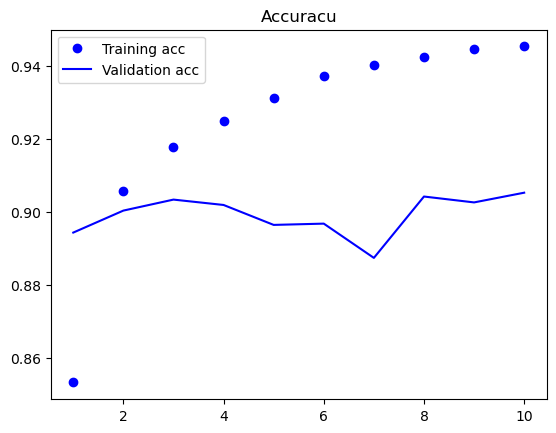

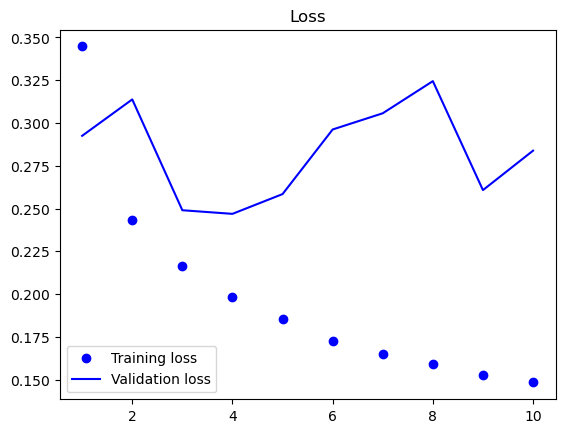

In [262]:
show_graph(history3)

## Рекуррентная модель со слоем LSTM

In [263]:
model4 = Sequential()
model4.add(Input(shape=(sentence_length, )))
model4.add(Embedding(max_words, embedding_dim))
model4.add(LSTM(64))
model4.add(Flatten())
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [264]:
history4 = model4.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1789/1789 [==============================] - 76s 42ms/step - loss: 0.3504 - acc: 0.8491 - val_loss: 0.2476 - val_acc: 0.9011
Epoch 2/10
1789/1789 [==============================] - 76s 42ms/step - loss: 0.2365 - acc: 0.9060 - val_loss: 0.2329 - val_acc: 0.9045
Epoch 3/10
1789/1789 [==============================] - 77s 43ms/step - loss: 0.1928 - acc: 0.9256 - val_loss: 0.2128 - val_acc: 0.9168
Epoch 4/10
1789/1789 [==============================] - 77s 43ms/step - loss: 0.1566 - acc: 0.9420 - val_loss: 0.2124 - val_acc: 0.9121
Epoch 5/10
1789/1789 [==============================] - 83s 46ms/step - loss: 0.1300 - acc: 0.9524 - val_loss: 0.2100 - val_acc: 0.9189
Epoch 6/10
1789/1789 [==============================] - 80s 45ms/step - loss: 0.1136 - acc: 0.9590 - val_loss: 0.2539 - val_acc: 0.9058
Epoch 7/10
1789/1789 [==============================] - 76s 43ms/step - loss: 0.0989 - acc: 0.9651 - val_loss: 0.2389 - val_acc: 0.9010
Epoch 8/10
1789/1789 [==========================

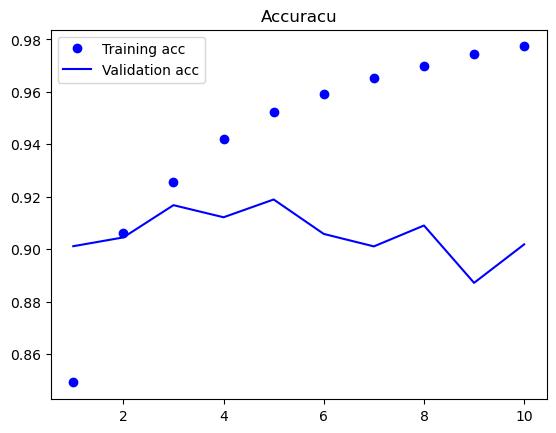

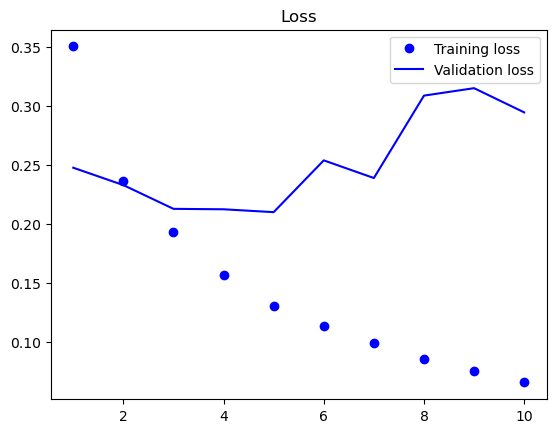

In [265]:
show_graph(history4)

## Рекуррентная модель с двумя рекуррентными слоями

In [266]:
model5 = Sequential()
model5.add(Input(shape=(sentence_length, )))
model5.add(Embedding(max_words, embedding_dim))
model5.add(LSTM(32, return_sequences=True))
model5.add(LSTM(32))
model5.add(Flatten())
model5.add(Dense(1, activation='sigmoid'))

model5.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics = ['acc'])

In [267]:
history5 = model5.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test,y_test))

Epoch 1/10
1789/1789 [==============================] - 72s 40ms/step - loss: 0.3073 - acc: 0.8659 - val_loss: 0.2866 - val_acc: 0.8799
Epoch 2/10
1789/1789 [==============================] - 69s 39ms/step - loss: 0.2221 - acc: 0.9124 - val_loss: 0.2500 - val_acc: 0.9015
Epoch 3/10
1789/1789 [==============================] - 69s 39ms/step - loss: 0.1891 - acc: 0.9272 - val_loss: 0.2171 - val_acc: 0.9111
Epoch 4/10
1789/1789 [==============================] - 69s 39ms/step - loss: 0.1617 - acc: 0.9391 - val_loss: 0.2128 - val_acc: 0.9153
Epoch 5/10
1789/1789 [==============================] - 71s 39ms/step - loss: 0.1407 - acc: 0.9487 - val_loss: 0.2411 - val_acc: 0.9030
Epoch 6/10
1789/1789 [==============================] - 70s 39ms/step - loss: 0.1245 - acc: 0.9552 - val_loss: 0.2133 - val_acc: 0.9145
Epoch 7/10
1789/1789 [==============================] - 70s 39ms/step - loss: 0.1099 - acc: 0.9609 - val_loss: 0.2400 - val_acc: 0.9096
Epoch 8/10
1789/1789 [==========================

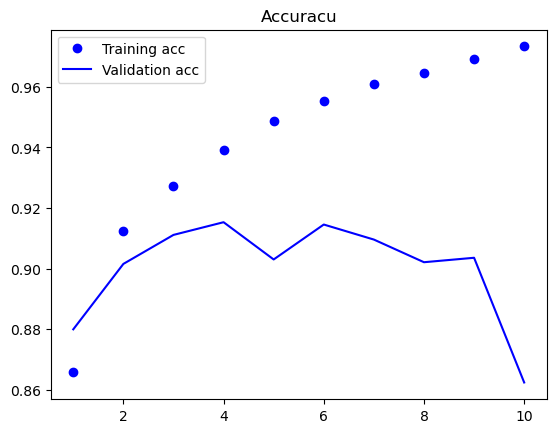

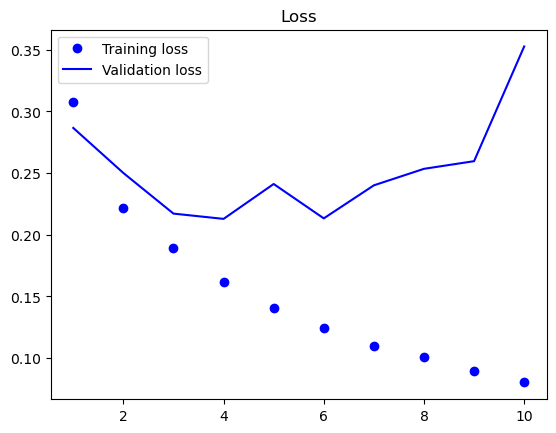

In [268]:
show_graph(history5)

## Анализ сходства слов в векторном пространстве

In [269]:
real_news = data[data['label'] == 0]['title'].tolist()
fake_news = data[data['label'] == 1]['title'].tolist()

In [270]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Функция для предварительной обработки текста
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление знаков пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    # Удаление стоп-слов
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Предварительная обработка заголовков настоящих и фейковых новостей
real_news_preprocessed = [preprocess_text(title) for title in real_news]
fake_news_preprocessed = [preprocess_text(title) for title in fake_news]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tainazitina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [271]:
from nltk.tokenize import word_tokenize
from collections import Counter

# Предварительная обработка данных для настоящих новостей
real_news_tokens = [word.lower() for title in real_news_preprocessed for word in word_tokenize(title)]
real_news_word_freq = Counter(real_news_tokens)

fake_news_tokens = [word.lower() for title in fake_news_preprocessed for word in word_tokenize(title)]
fake_news_word_freq = Counter(fake_news_tokens)

In [272]:
# Получение наиболее частых слов для настоящих новостей
top_real_words = real_news_word_freq.most_common(10)
print("Top words in real news headlines:")
for word, freq in top_real_words:
    print(f"{word}: {freq}")
    
# Получение наиболее частых слов для фейковых новостей
top_fake_words = fake_news_word_freq.most_common(10)
print("\nTop words in fake news headlines:")
for word, freq in top_fake_words:
    print(f"{word}: {freq}")

Top words in real news headlines:
new: 7703
trump: 7072
york: 6467
times: 6363
us: 4593
says: 3352
breitbart: 2398
house: 1774
trumps: 1200
clinton: 1188

Top words in fake news headlines:
trump: 8848
video: 8784
hillary: 3022
obama: 2086
clinton: 2068
watch: 2041
us: 1774
trumps: 1701
new: 1464
news: 1310


In [279]:
real_words_index = []
i = 0
for word in vocabulary: 
  i += 1
  for word2, freq in top_real_words:
    if word == word2:
      real_words_index.append(i)
      print(word)
print()
fake_words_index = []
i = 0
for word in vocabulary: 
  i += 1
  for word2, freq in top_fake_words:
    if word == word2:
      fake_words_index.append(i)
      print(word)

trump
new
york
clinton
house
us
times

trump
new
video
hillary
clinton
obama
watch
news
us


[('new', 7703), ('trump', 7072), ('york', 6467), ('times', 6363), ('us', 4593), ('says', 3352), ('house', 1774), ('trumps', 1200), ('clinton', 1188)]
[('new', 7703), ('trump', 7072), ('york', 6467), ('times', 6363), ('us', 4593), ('house', 1774), ('clinton', 1188)]


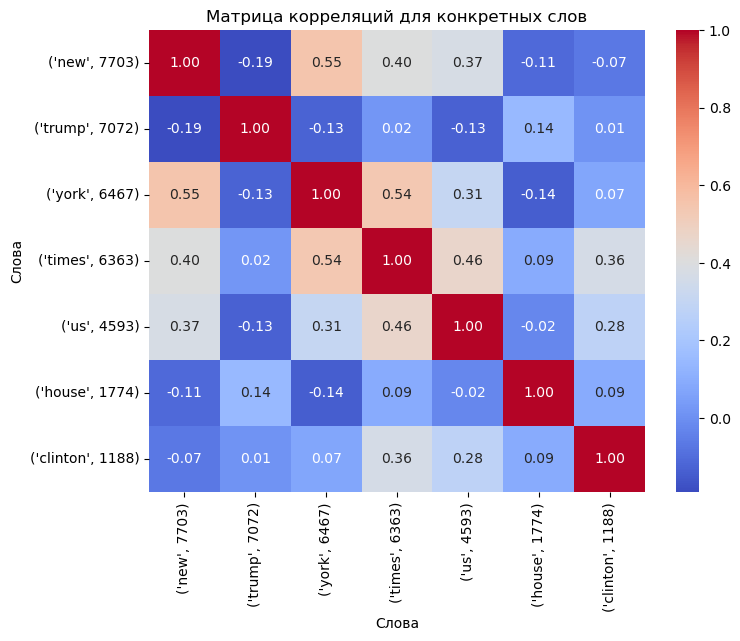

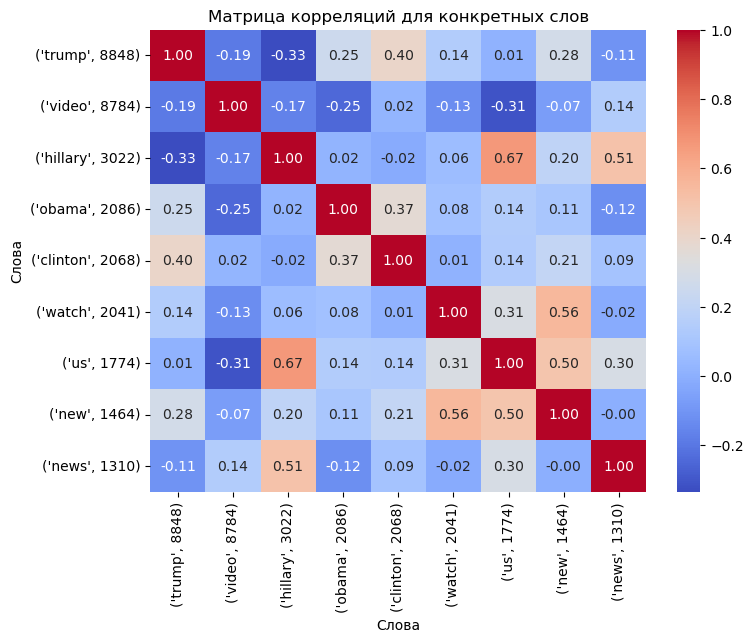

In [289]:
word_embeddings = model5.layers[0].get_weights()[0]

# Получите векторы представлений этих слов
real_word_embeddings = word_embeddings[real_words_index]
fake_word_embeddings = word_embeddings[fake_words_index]

# Вычислите матрицу корреляций
real_correlation_matrix = np.corrcoef(real_word_embeddings)
fake_correlation_matrix = np.corrcoef(fake_word_embeddings)

top_real_words_2 = top_real_words[0:5] + top_real_words[6:7] + top_real_words[8:]
top_fake_words_2 = top_fake_words[0:7] + top_fake_words[8:]

plt.figure(figsize=(8, 6))
sns.heatmap(real_correlation_matrix, annot=True, xticklabels=top_real_words_2, yticklabels=top_real_words_2, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций для конкретных слов")
plt.xlabel("Слова")
plt.ylabel("Слова")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(fake_correlation_matrix, annot=True, xticklabels=top_fake_words_2, yticklabels=top_fake_words_2, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций для конкретных слов")
plt.xlabel("Слова")
plt.ylabel("Слова")
plt.show()

In [275]:
real_words_vectors = []
for word, _ in top_real_words:
    try:
        vector = word_vectors[word]
        real_words_vectors.append(vector)
    except KeyError:
        print(f"Word '{word}' not present in the pretrained model. Skipping.")
        
fake_words_vectors = []
for word, _ in top_fake_words:
    try:
        vector = word_vectors[word]
        fake_words_vectors.append(vector)
    except KeyError:
        print(f"Word '{word}' not present in the pretrained model. Skipping.")

Word 'breitbart' not present in the pretrained model. Skipping.


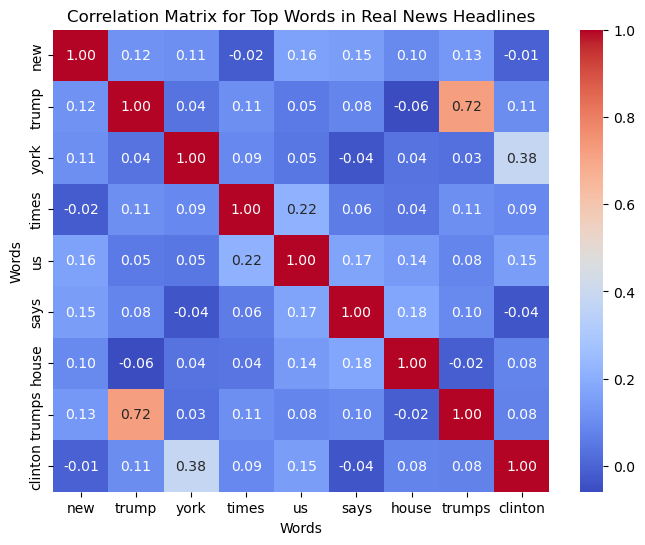

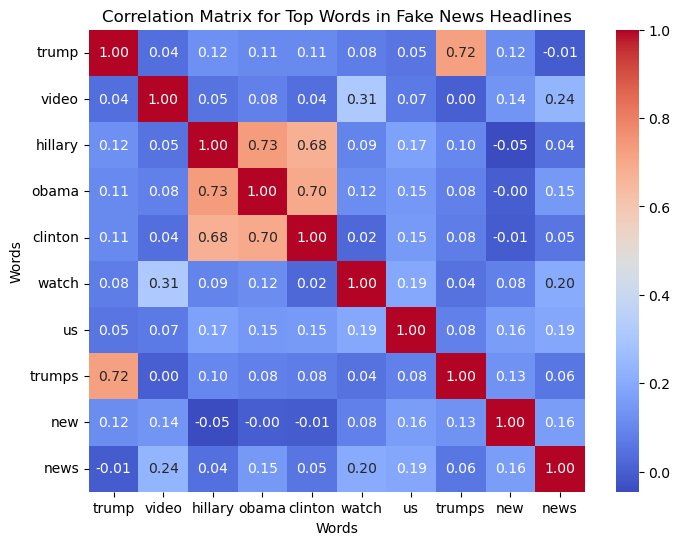

In [277]:
# Построение матрицы корреляций для характерных слов настоящих новостей
real_words_corr = np.corrcoef(np.array(real_words_vectors))

# Построение матрицы корреляций для характерных слов фейковых новостей
fake_words_corr = np.corrcoef(np.array(fake_words_vectors))

top_real_words.pop(6)

# Визуализация матрицы корреляций для настоящих новостей
plt.figure(figsize=(8, 6))
sns.heatmap(real_words_corr, annot=True, xticklabels=[word for word, _ in top_real_words], yticklabels=[word for word, _ in top_real_words], cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Top Words in Real News Headlines")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()

# Визуализация матрицы корреляций для фейковых новостей
plt.figure(figsize=(8, 6))
sns.heatmap(fake_words_corr, annot=True, xticklabels=[word for word, _ in top_fake_words], yticklabels=[word for word, _ in top_fake_words], cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Top Words in Fake News Headlines")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()